
# Install tensorflow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1EubZE0VOCApZ4MzCBCUe9VVskPe_AQTt)

In [1]:
!pip install --upgrade pip

# Autoencoders

Autoencoders are neural networks trained to reproduce the input: the model is a regressor where the target is the same as the input.

Autoencoders can be used to find lower-dimensional representation of the data. In this case, one of the hidden layers, typically the middle one, is the "code", i.e. the compressed representation of the input data.

![picture](https://drive.google.com/uc?id=1drlrT_f2_sAX1u65npWWv2wOLti8NfVs)

Contary to PCA, autoencoders are powerful non-linear models that can discover non-linear correlations among features.

![picture](https://drive.google.com/uc?id=1og8kGSLkSnKIeUKg1xSAfmv5JFfIZNIt)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 
import pandas as pd 

In [4]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__

'2.9.1'

In [5]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/qk/0_srvgns7zscwh127pk191h00000gn/T/pip-req-build-2aju0rth
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/qk/0_srvgns7zscwh127pk191h00000gn/T/pip-req-build-2aju0rth
  Resolved https://github.com/tensorflow/docs to commit 613618a5ce6f0acfd0d70e475bb6e46fae18c843
  Preparing metadata (setup.py) ... done


# Sample problem : Mnist

Train a neural network model to encode images 28x28 pixels (768 pixels) representing **hand-written digits** in a 16-dimensional vector.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how much accurate is the lower representation. You can access the MNIST directly from TensorFlow. Import and load the MNIST data directly from TensorFlow:



In [6]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9.

## Explore the data
Image shape : 60,000 x 28 x 28

Each image is represented as a 2 dimensional matrix of 28 x 28

In [7]:
train_images.shape, len(train_labels)

((60000, 28, 28), 60000)

In [11]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [12]:
test_images.shape, len(test_labels)

((10000, 28, 28), 10000)

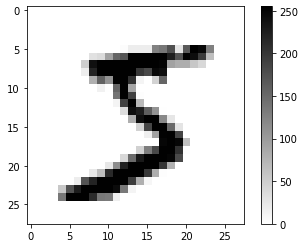

In [13]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocess images
Normalize pixel values in the range [0, 1], i.e. divide by 255.

In [14]:
# important to perform each processing step separately on train and test 

train_images = train_images / 255.0
test_images = test_images / 255.0

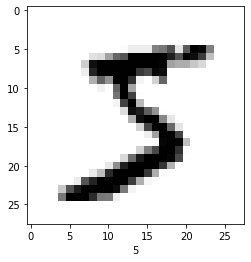

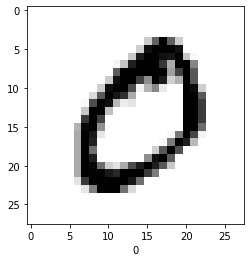

In [15]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.show()
plt.imshow(train_images[1], cmap=plt.cm.binary)
plt.xlabel(train_labels[1])
plt.show()

# Build the model and pipeline using Sequential API

## Setup layers

In [17]:
input_img = keras.Input(shape=(28, 28), name='image')
encoded = layers.Flatten(name='flatten')(input_img)
encoded = layers.Dense(128, activation='relu', name='enc_hidden')(encoded)
encoded = layers.Dense(16, activation='relu', name='enc_output')(encoded)

decoded = layers.Dense(128, activation='relu', name='dec_hidden')(encoded)
decoded = layers.Dense(784, activation='sigmoid', name='dec_output')(decoded)
decoded = layers.Reshape((28, 28), name='reshape')(decoded)

## Compile the model

Compiling the model means setting up the optimizer and loss function

* **Loss function** —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* **Optimizer** —This is how the model is updated based on the data it sees and its loss function.

In [18]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 enc_hidden (Dense)          (None, 128)               100480    
                                                                 
 enc_output (Dense)          (None, 16)                2064      
                                                                 
 dec_hidden (Dense)          (None, 128)               2176      
                                                                 
 dec_output (Dense)          (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0     

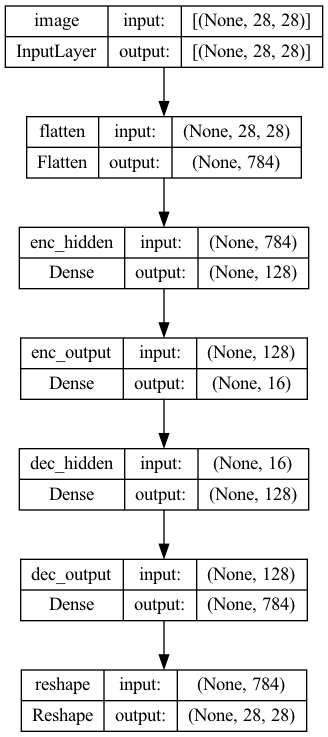

In [20]:
keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

# Train the model
Training the neural network model requires the following steps:

1. Feed the training data to the model. **In an autoencoder, the input is the same as the target** (`train_images`).
2. The model learns to encode the image information in a 16-dimensional vector and decode it back.
3. You ask the model to encode and decode the original images.
4. Verify that the original images resembles the recovered images.

In [21]:
# tensorboard settings to view plots
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 3s 10ms/step - loss: 0.2521 - val_loss: 0.1789
Epoch 2/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1639 - val_loss: 0.1513
Epoch 3/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1460 - val_loss: 0.1392
Epoch 4/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1382 - val_loss: 0.1343
Epoch 5/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1342 - val_loss: 0.1311
Epoch 6/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1303 - val_loss: 0.1264
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1262 - val_loss: 0.1227
Epoch 8/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1230 - val_loss: 0.1203
Epoch 9/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1210 - val_loss: 0.1188
Epoch 10/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1195 - val_

235/235 [==============================] - 2s 8ms/step - loss: 0.1038 - val_loss: 0.1037
Epoch 82/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1038 - val_loss: 0.1036
Epoch 83/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1037 - val_loss: 0.1036
Epoch 84/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1036 - val_loss: 0.1035
Epoch 85/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1036 - val_loss: 0.1034
Epoch 86/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1035 - val_loss: 0.1034
Epoch 87/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1035 - val_loss: 0.1033
Epoch 88/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1035 - val_loss: 0.1034
Epoch 89/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1034 - val_loss: 0.1032
Epoch 90/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1034 - val_los

## Evaluate the model on test set

313/313 [==============================] - 1s 1ms/step


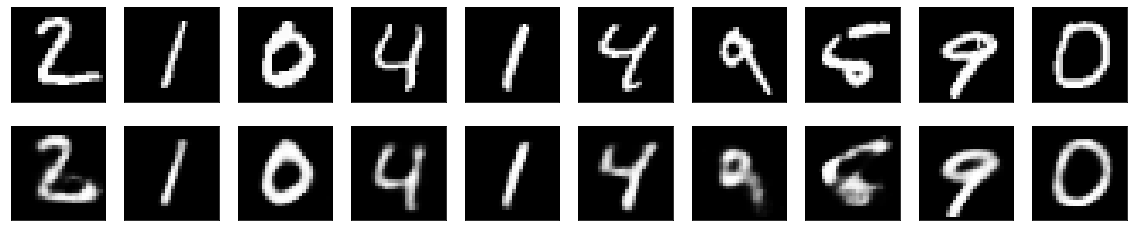

In [22]:
decoded_imgs = autoencoder.predict(test_images)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Embeddings
We use the trained layers in order to get the core representation in the middle layer of the autoencoder, and we represent them with the TSNE


In [23]:
embeddings = keras.Model(input_img, encoded).predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [24]:
from sklearn.manifold import TSNE
import numpy as np

In [25]:
tsne = TSNE(n_components=2)

In [26]:
emb2d = tsne.fit_transform(embeddings)

/Users/gioiaboschi/venvs/myenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/gioiaboschi/venvs/myenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [27]:
x,y = np.squeeze(emb2d[:, 0]), np.squeeze(emb2d[:, 1])

In [28]:
import pandas as pd

In [29]:
from matplotlib.cm import tab10

(-83.03480529785156, 102.39952087402344, -84.89695663452149, 78.33879013061524)

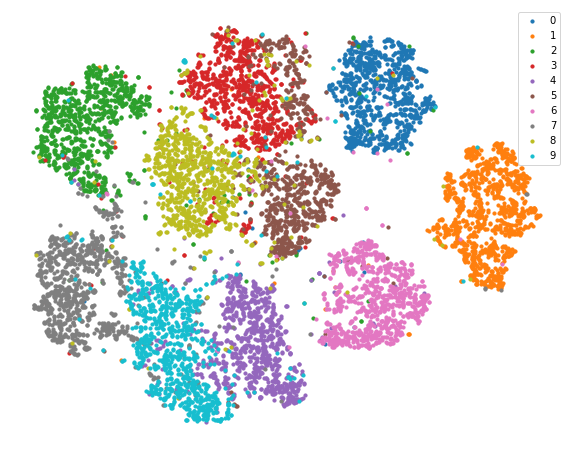

In [30]:
summary =  pd.DataFrame({"x": x, "y": y, "target": test_labels, "size": 10})

plt.figure(figsize=(10,8))

for key, sel in summary.groupby("target"):
    plt.scatter(sel["x"], sel["y"], s=10, color=tab10.colors[key], label=key)
    
plt.legend()
plt.axis("off")

# Add denoising
Autoencoders can be quite unstable when presented with even slightly different input distributions. In this example, we add Gaussian noise to the original images. They do seem very similar to the original images, yet the autoencoder fails to reproduce them.

Denoising Autoencoders (DAE) are more robust compared to "vanilla" autoencoders.

In [31]:
noise_factor = 0.1
x_train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
x_test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

313/313 [==============================] - 0s 1ms/step


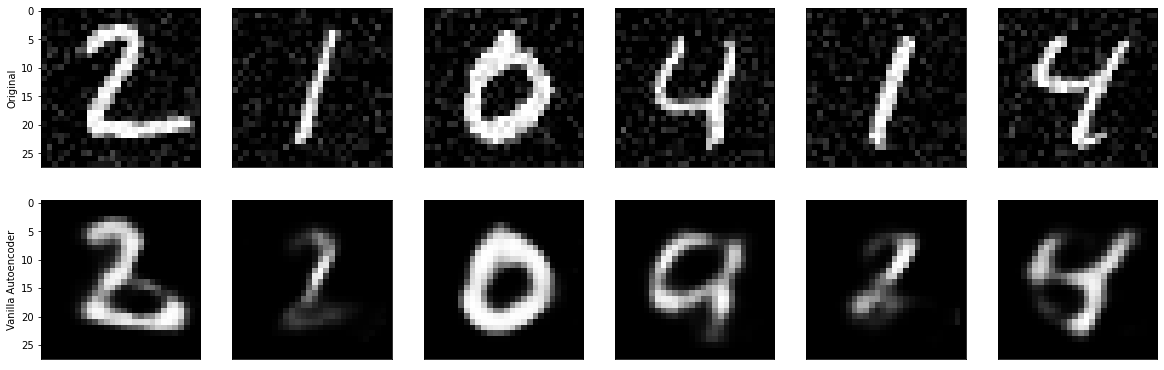

In [32]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

In [33]:
from tensorflow.keras.layers import GaussianNoise

In [34]:
input_img = keras.Input(shape=(28, 28), name='image')

noisy_input = GaussianNoise(0.1, name='gaussian_noise')(input_img)

encoded = layers.Flatten(name='flatten')(noisy_input)
encoded = layers.Dense(128, activation='relu', name='enc_hidden')(encoded)
encoded = layers.Dense(16, activation='relu', name='enc_output')(encoded)

decoded = layers.Dense(128, activation='relu', name='dec_hidden')(encoded)
decoded = layers.Dense(784, activation='sigmoid', name='dec_output')(decoded)
decoded = layers.Reshape((28, 28), name='reshape')(decoded)

In [35]:
noisy_autoencoder = keras.Model(input_img, decoded)
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

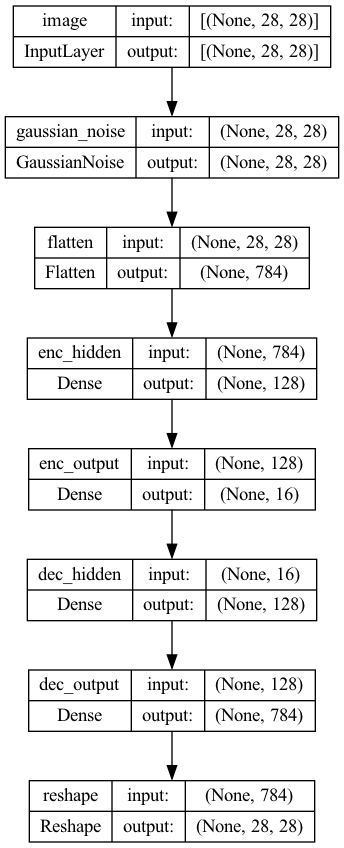

In [36]:
keras.utils.plot_model(noisy_autoencoder, show_shapes=True, show_layer_names=True)

In [37]:
noisy_autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 3s 10ms/step - loss: 0.2489 - val_loss: 0.1709
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1558 - val_loss: 0.1410
Epoch 3/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1370 - val_loss: 0.1287
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1286 - val_loss: 0.1234
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1248 - val_loss: 0.1206
Epoch 6/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1224 - val_loss: 0.1185
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1206 - val_loss: 0.1169
Epoch 8/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1191 - val_loss: 0.1156
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1178 - val_loss: 0.1147
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1167

Epoch 81/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0985 - val_loss: 0.0965
Epoch 82/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0984 - val_loss: 0.0964
Epoch 83/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0983 - val_loss: 0.0963
Epoch 84/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0983 - val_loss: 0.0963
Epoch 85/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0983 - val_loss: 0.0961
Epoch 86/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0982 - val_loss: 0.0962
Epoch 87/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0982 - val_loss: 0.0961
Epoch 88/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0981 - val_loss: 0.0959
Epoch 89/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0981 - val_loss: 0.0961
Epoch 90/100
235/235 [==============================] - 2s 10ms/step - loss: 0.

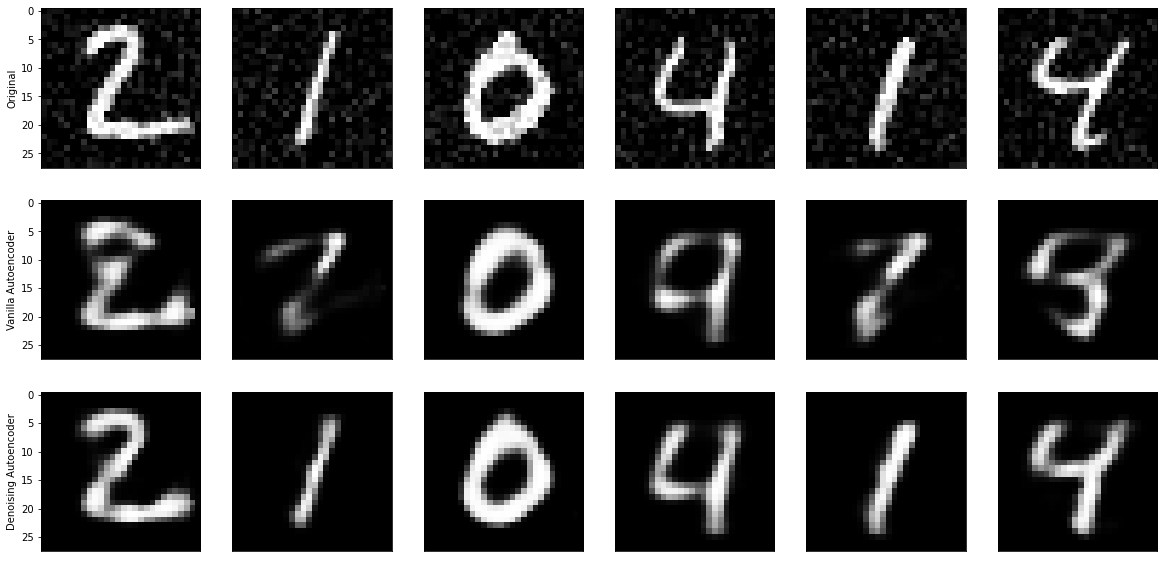

In [34]:
decoded_imgs = autoencoder.predict(x_test_noisy)

decoded_imgs_denoised = noisy_autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

# Noise removal

Autoencoders can have different architectures depending on the goal.

In this example, the focus is on the noise removal. In this case, we do not need the encoder-decoder structure, since our goal is not to compress the images in a lower-dimensional representation bu rather to **generate new images with the noise removed**. This model belongs to the class of **generative** models.

In [38]:
from numpy.random import default_rng
from keras.utils import tf_utils

rng = default_rng()

def salt_and_pepper(inputs, rate):
    shp = tf.shape(inputs)
    mask_select = rng.binomial(n=1, p=rate, size=shp)
    mask_noise = rng.binomial(n=1, p=0.5, size=shp) # salt and pepper have the same chance
    out = inputs * (1-mask_select) + mask_noise * mask_select
    return out

Distinguish learning/testing phase and apply the layer accordingly

In [39]:
# Same structure of Gaussian Noise:

class SaltAndPepperNoise(keras.layers.Layer):

    def __init__(self, rate, **kwargs):
        super(SaltAndPepperNoise, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        def noised():
            shp = keras.backend.shape(inputs)[1:]
            mask_select = keras.backend.random_bernoulli(shape=shp, p=self.rate)
            mask_noise = keras.backend.random_bernoulli(shape=shp, p=0.5) # salt and pepper have the same chance
            out = inputs * (1-mask_select) + mask_noise * mask_select
            return out

        return keras.backend.in_train_phase(noised(), inputs, training=training)

    @tf_utils.shape_type_conversion
    def compute_output_shape(self, input_shape):
        return input_shape

In [40]:
noise_rate = 0.3
train_images_saltpepper = salt_and_pepper(train_images, noise_rate)
test_images_saltpepper = salt_and_pepper(test_images, noise_rate)

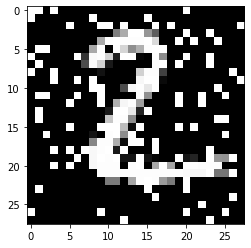

In [41]:
plt.imshow(test_images_saltpepper[1].reshape(28, 28))

In [42]:
input_img = keras.Input(shape=(28, 28), name='noisy_image')

noisy_input = SaltAndPepperNoise(noise_rate, name='salt_and_pepper')(input_img)

encoded = layers.Flatten(name='flatten')(noisy_input)
encoded = layers.Dense(1000, activation='relu', name='dense_hidden')(encoded)
encoded = layers.Dense(784, activation='sigmoid', name='output_image')(encoded)
output = layers.Reshape((28, 28), name='reshape')(encoded)

In [43]:
noise_removal_dae = keras.Model(input_img, output)
noise_removal_dae.compile(optimizer='adam', loss='binary_crossentropy')

In [44]:
print(noise_removal_dae.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_image (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 salt_and_pepper (SaltAndPep  (None, 28, 28)           0         
 perNoise)                                                       
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_hidden (Dense)        (None, 1000)              785000    
                                                                 
 output_image (Dense)        (None, 784)               784784    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                           

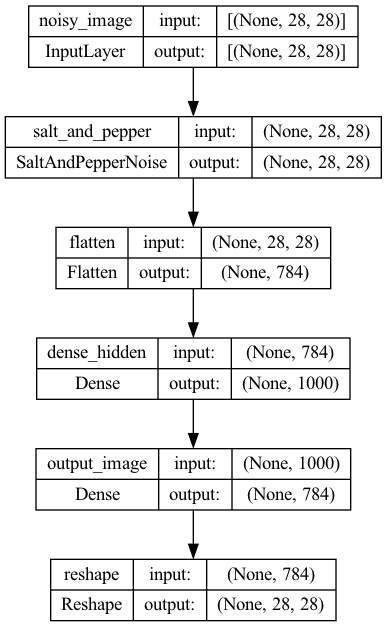

In [45]:
keras.utils.plot_model(noise_removal_dae, show_shapes=True, show_layer_names=True)

In [46]:
noise_removal_dae.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 7s 27ms/step - loss: 0.1943 - val_loss: 0.1835
Epoch 2/100
235/235 [==============================] - 6s 23ms/step - loss: 0.1433 - val_loss: 0.1536
Epoch 3/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1348 - val_loss: 0.1482
Epoch 4/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1287 - val_loss: 0.1373
Epoch 5/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1247 - val_loss: 0.1398
Epoch 6/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1217 - val_loss: 0.1294
Epoch 7/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1209 - val_loss: 0.1383
Epoch 8/100
235/235 [==============================] - 5s 23ms/step - loss: 0.1187 - val_loss: 0.1338
Epoch 9/100
235/235 [==============================] - 6s 23ms/step - loss: 0.1172 - val_loss: 0.1295
Epoch 10/100
235/235 [==============================] - 6s 24ms/step - loss: 0.115

235/235 [==============================] - 5s 21ms/step - loss: 0.1011 - val_loss: 0.1063
Epoch 81/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1012 - val_loss: 0.0959
Epoch 82/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1008 - val_loss: 0.0956
Epoch 83/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1008 - val_loss: 0.0995
Epoch 84/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1013 - val_loss: 0.0997
Epoch 85/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1010 - val_loss: 0.0989
Epoch 86/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1007 - val_loss: 0.1004
Epoch 87/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1008 - val_loss: 0.1005
Epoch 88/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1008 - val_loss: 0.1032
Epoch 89/100
235/235 [==============================] - 5s 20ms/step - loss: 0.1010 - 

313/313 [==============================] - 1s 2ms/step


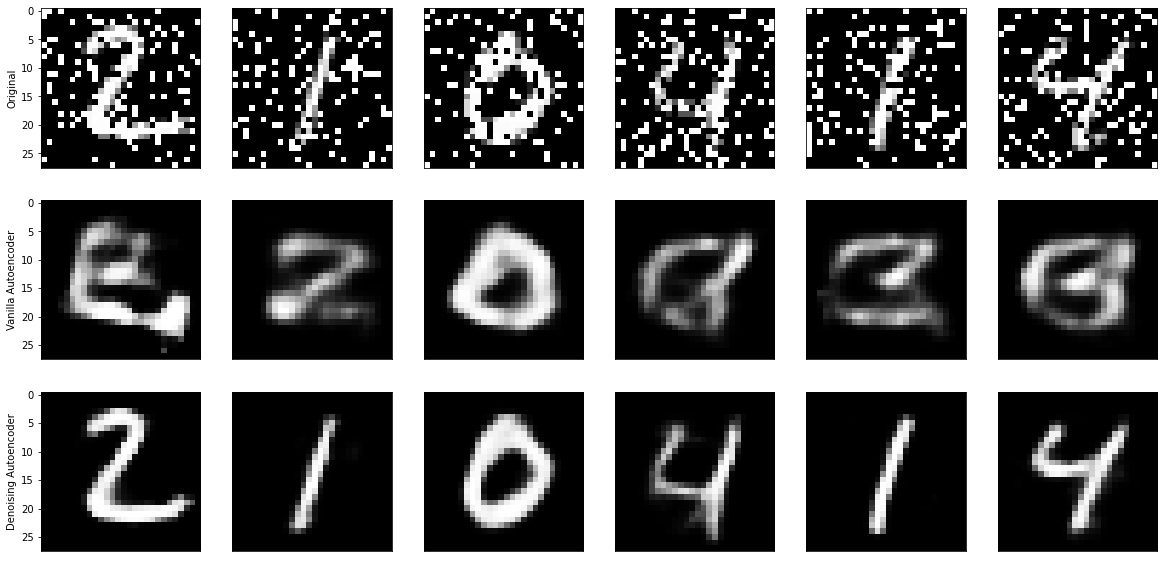

In [47]:
decoded_imgs = autoencoder.predict(test_images_saltpepper)

decoded_imgs_denoised = noise_removal_dae.predict(test_images_saltpepper)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images_saltpepper[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()